<a href="https://colab.research.google.com/github/wvirany/mini_projects/blob/main/double_descent/adaboost_interpolating_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [280]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.ensemble import AdaBoostClassifier as AdaBoost
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import zero_one_loss as loss

In [281]:
cm = plt.cm.RdBu
cm_bright = ListedColormap(["tomato", "#0000FF"])

In [282]:
num_samples = 250
p = .8

### Pure Noise Dataset

In [283]:
X1 = np.random.random_sample(size=num_samples)
X2 = np.random.random_sample(size=num_samples)

X = np.stack((X1, X2), axis=1)
y = np.random.binomial(n=1, p=p, size=num_samples)

pure_noise_dataset = (X, y)

### Noisy Signal Dataset

In [284]:
X1 = np.random.random_sample(size=num_samples)
X2 = np.random.random_sample(size=num_samples)
X = np.stack((X1, X2), axis=1)

y = np.zeros(num_samples)

for i, sample in enumerate(X):

  if (sample[0] - .5)**2 + (sample[1] - .5)**2 < .1:
    y[i] = np.random.binomial(n=1, p=1-p)

  else:
    y[i] = np.random.binomial(n=1, p=p)

noisy_signal_dataset = (X,y)

### Pure Signal Dataset

In [285]:
X1 = np.random.random_sample(size=num_samples)
X2 = np.random.random_sample(size=num_samples)
X = np.stack((X1, X2), axis=1)

y = np.zeros(num_samples)

for i, sample in enumerate(X):

  if (sample[0] - .5)**2 + (sample[1] - .5)**2 < .1:
    y[i] = 0

  else:
    y[i] = 1

pure_signal_dataset = (X, y)

## Classification

In [286]:
datasets = [
    pure_noise_dataset,
    noisy_signal_dataset,
    pure_signal_dataset
]

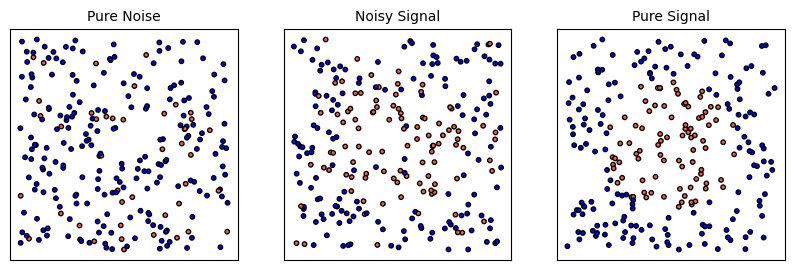

In [287]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 3))

titles = [
    'Pure Noise',
    'Noisy Signal',
    'Pure Signal'
]

for i, j in enumerate(datasets):

  X, y = j

  axes[i].scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright, ec='k', s=10)
  axes[i].set_title(titles[i], fontsize=10)

# Removing axis ticks
tick_params = {
    'axis': 'both',
    'which': 'both',
    'left': False,
    'bottom': False,
    'labelbottom': False,
    'labelleft': False
}

[axes[i].tick_params(**tick_params) for i in range(3)];

In [288]:
X, y = datasets[0]
noise = 1

clf = AdaBoost(n_estimators=1000, algorithm='SAMME', random_state=42)
clf.fit(X, y);

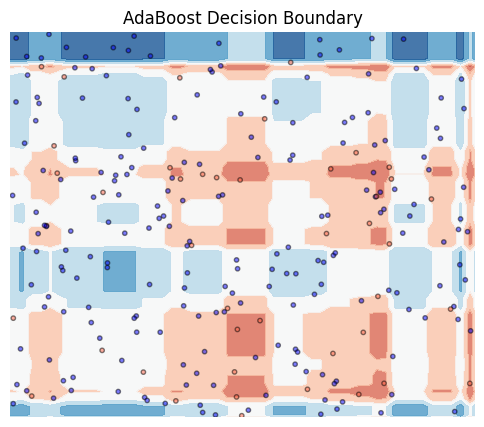

In [289]:
fig, ax = plt.subplots(figsize=(6,5))

DecisionBoundaryDisplay.from_estimator(clf, X, cmap=cm, alpha=.8, ax=ax, eps=.5)

ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright, ec='k', alpha=.5, s=10)

ax.set_title('AdaBoost Decision Boundary')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.axis('off');

In [290]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.8, random_state=42, stratify=y)

In [291]:
train_loss = []
test_loss = []

for i in range(1, 100, 1):

  clf = AdaBoost(n_estimators=i, algorithm='SAMME', random_state=42)
  clf.fit(X_train, y_train)

  train_pred = clf.predict(X_train)
  test_pred = clf.predict(X_test)

  train_loss.append(loss(y_train, train_pred))
  test_loss.append(loss(y_test, test_pred))

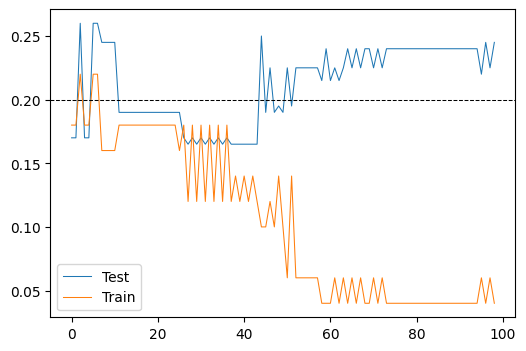

In [292]:
fig, ax = plt.subplots(figsize=(6,4))


ax.plot(test_loss, label='Test', lw=.75)
ax.plot(train_loss, label='Train', lw=.75)

if noise:
  ax.axhline(1-p, ls='dashed', c='k', lw=.75)

# plt.xscale('log')

ax.legend();

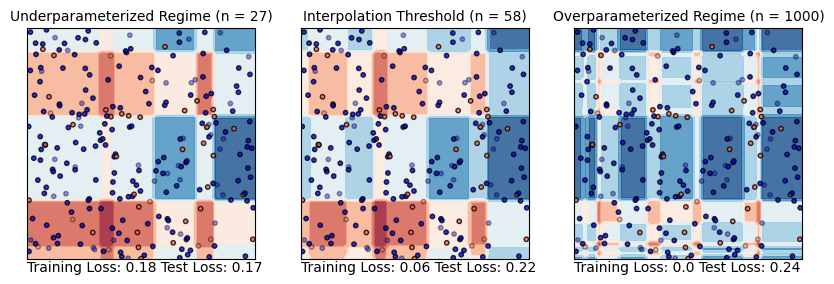

In [293]:
num_estimators = [np.argmin(test_loss[2:50]) + 2, np.argmin(train_loss), 1000]
titles = [
    'Underparameterized Regime (n = ' + str(num_estimators[0]) + ')',
    'Interpolation Threshold (n = ' + str(num_estimators[1]) + ')',
    'Overparameterized Regime (n = ' + str(num_estimators[2]) + ')'
]

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 3))

for i, j in enumerate(num_estimators):

  clf = AdaBoost(n_estimators = j, algorithm='SAMME', random_state=42)
  clf.fit(X_train, y_train)

  train_pred = clf.predict(X_train)
  test_pred = clf.predict(X_test)

  loss1 = round(loss(y_train, train_pred), 2)
  loss2 = round(loss(y_test, test_pred), 2)

  DecisionBoundaryDisplay.from_estimator(clf, X, cmap=cm, alpha=.8, ax=axes[i], eps=.5)

  subtitle = 'Training Loss: ' + str(loss1) + ' Test Loss: ' + str(loss2)

  axes[i].scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, ec='k', alpha=.4, s=10)
  axes[i].scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, ec='k', alpha=.8, s=10)
  axes[i].set_title(titles[i], fontsize=10)
  axes[i].text(x=0, y=-.05, s=subtitle, fontsize=10)
  axes[i].set_xlim(0, 1)
  axes[i].set_ylim(0, 1)

# Removing axis ticks
tick_params = {
    'axis': 'both',
    'which': 'both',
    'left': False,
    'bottom': False,
    'labelbottom': False,
    'labelleft': False
}

[axes[i].tick_params(**tick_params) for i in range(3)];